In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from imagenet_preprocessing import input_fn, _NUM_TRAIN_FILES, NUM_IMAGES
import random
import os
import glob
import re

%load_ext autoreload
%autoreload 2

tf.__version__

'2.7.0'

## ImageNet Input data

In [2]:
!rm -r /training-data/cache_temp/snapshot*
data_dir = "/training-data/imagenet2012/tfrecords"; nb_train_imgs=1281167 # ImageNet
#data_dir = "/training-data/imagenet-tiny/tfrecords"; nb_train_imgs=100000 # Tiny
#data_dir = "/training-data/imagenet_test/tfrecords"; nb_train_imgs=4 # contains 4 images

batch_size = 64 #
#i=1
#filenames = [f"{data_dir}/train-{i:05d}-of-{_NUM_TRAIN_FILES:05d}"]
filenames = None

ds = input_fn(
    is_training=True,
    data_dir=data_dir,
    batch_size=batch_size,
    dtype=tf.float16,
    datasets_num_private_threads=4,
    drop_remainder=False,
    filenames=filenames,
)

rm: cannot remove '/training-data/cache_temp/snapshot*': No such file or directory


In [ ]:
# Display the first few batches of each epoch

dataset = ds
nb_imgs_per_batch_to_show = 5

batch_start_idx = 0
nb_batches = 1
epochs = range(8)

batch_idx_1st_ep = set(range(batch_start_idx, batch_start_idx+nb_batches))
batches_per_ep = nb_train_imgs//batch_size
batch_idx_to_show = set([b + ep*batches_per_ep for ep in epochs for b in batch_idx_1st_ep])
#batch_idx_to_show = set([b + shift + ep*batches_per_ep for ep in epochs for b in batch_idx_1st_ep for shift in [0, batches_per_ep/2]])

batch_idx=0
for images, label in dataset.as_numpy_iterator():  # example is (image, label)
    if len(batch_idx_to_show) == 0:
        break
    if batch_idx in batch_idx_to_show:
        batch_idx_to_show.remove(batch_idx)
        print(f"epoch {batch_idx // batches_per_ep} batch {batch_idx%batches_per_ep}")

        fig, ax = plt.subplots(nrows=1, ncols=nb_imgs_per_batch_to_show, figsize=(2*nb_imgs_per_batch_to_show, 10))
        i=0
        for col in ax: # iterate over batch elem
            image = images[i].astype(np.float32)
            #print(label.numpy()[i,0])
            image = (image+abs(np.min(image)))/(np.max(image)-np.min(image))
            col.imshow(np.squeeze(image))
            i+=1
        plt.show()

    batch_idx+=1

In [4]:
#iterate for one epoch
ds_iterator = iter(ds)
for b in range(nb_train_imgs//batch_size):
    batch_ep2, targets2 = next(ds_iterator)

In [26]:
cache_loc = "/training-data/cache_temp"
cached_dataset = tf.data.experimental.serviceCacheGetDataset(cache_loc, element_spec)
cached_dataset

<_ServiceCacheGetDataset shapes: ((312, 64, 64, 3), (312, 1)), types: (tf.float16, tf.float32)>

# Caching service

In [7]:
def data_augm(x):
    return x+str(random.randint(1,4))

cache_loc = "/home/tgyal/cache_temp"
raw_dataset = tf.data.Dataset.from_tensor_slices(["1--", "2----", "3------"])
raw_dataset = raw_dataset.map(lambda x: data_augm(x))



#raw_dataset = raw_dataset.apply(tf.data.experimental.service_cache_put(cache_loc))
element_spec = raw_dataset.element_spec

raw_dataset = raw_dataset.repeat(3)

print("Non-cached version")
for x in raw_dataset:
    print(x)

Non-cached version
tf.Tensor(b'1--3', shape=(), dtype=string)
tf.Tensor(b'2----3', shape=(), dtype=string)
tf.Tensor(b'3------3', shape=(), dtype=string)
tf.Tensor(b'1--3', shape=(), dtype=string)
tf.Tensor(b'2----3', shape=(), dtype=string)
tf.Tensor(b'3------3', shape=(), dtype=string)
tf.Tensor(b'1--3', shape=(), dtype=string)
tf.Tensor(b'2----3', shape=(), dtype=string)
tf.Tensor(b'3------3', shape=(), dtype=string)


In [5]:
cached_dataset = tf.data.experimental.serviceCacheGetDataset(cache_loc, element_spec)
cached_dataset = cached_dataset.repeat(2)

print("Cached version")

for x in cached_dataset:
  print(x)

Cached version


In [ ]:
dataset = raw_dataset.concatenate(cached_dataset)
dataset = dataset.repeat()
for x in dataset.take(10):
  print(x)

tf.Tensor(b'1--1', shape=(), dtype=string)
tf.Tensor(b'2----1', shape=(), dtype=string)
tf.Tensor(b'3------1', shape=(), dtype=string)
tf.Tensor(b'1--1', shape=(), dtype=string)
tf.Tensor(b'2----1', shape=(), dtype=string)
tf.Tensor(b'3------1', shape=(), dtype=string)
tf.Tensor(b'1--1', shape=(), dtype=string)
tf.Tensor(b'2----1', shape=(), dtype=string)
tf.Tensor(b'3------1', shape=(), dtype=string)
tf.Tensor(b'1--1', shape=(), dtype=string)


## Get Statistics from output log

In [2]:
pattern="resnet50*.txt"
log_dir = os.getenv("HOME") + "/logs/"
log_files = sorted([path.split("/")[-1] for path in glob.glob(log_dir+pattern)])
log_files

['resnet50-Baseline_Service1worker-2021-08-10-20h51m39.txt',
 'resnet50-Baseline_Service2workers-2021-08-10-17h54m18.txt',
 'resnet50-Baseline_Service4workers-2021-08-10-16h42m10.txt',
 'resnet50-Baseline_Service8workers-2021-08-10-14h41m04.txt',
 'resnet50-PeriodicCaching1in2_Gluster_cacheOps-2021-08-06-17h09m36.txt',
 'resnet50-Test-2021-07-20-13h55m30.txt',
 'resnet50-Test-2021-07-20-14h48m18.txt',
 'resnet50-Test-2021-07-21-11h46m18.txt',
 'resnet50-Test-2021-07-21-11h56m24.txt',
 'resnet50-Test-2021-07-21-11h59m04.txt',
 'resnet50-Test-2021-07-21-11h59m23.txt',
 'resnet50-Test-2021-07-21-13h59m43.txt',
 'resnet50-Test-2021-07-21-14h00m24.txt',
 'resnet50-Test-2021-07-21-14h08m14.txt',
 'resnet50-Test-2021-07-21-14h08m51.txt',
 'resnet50-Test-2021-07-21-14h10m27.txt']

In [3]:
log_files = ['resnet50-Baseline_Service1worker-2021-08-10-20h51m39.txt',
             'resnet50-Baseline_Service2workers-2021-08-10-17h54m18.txt',
 'resnet50-Baseline_Service4workers-2021-08-10-16h42m10.txt',
 'resnet50-Baseline_Service8workers-2021-08-10-14h41m04.txt']
#log_files = ['efficientnetv2-b0-PeriodicCaching1in6-2021-08-07-20h51m42.txt']

log_dir = os.getenv("HOME") + "/logs/"
pattern = "TimeHistory: (\d+.\d+) seconds"
nb_epochs = 90
ignore_first = True
# Default
cache_period = None
cache_writing_epochs = None if cache_period is None else np.array(range(nb_epochs))[0::cache_period]
cache_reading_epochs = None if cache_writing_epochs is None else np.delete(range(nb_epochs), cache_writing_epochs)
processing_epochs = None

for log_file in log_files:
    print("--------------------------------------")
    print(log_file)
    print("--------------------------------------")
    
    epoch_times = []
    log_path = log_dir + log_file
    for i, line in enumerate(open(log_path)):
        time = re.findall(pattern, line)
        epoch_times += time
    
    epoch_times = np.array([float(t) for t in epoch_times])
    if ignore_first:
        epoch_times = epoch_times[1:]
    mean_t = np.mean(epoch_times)
    median_t = np.median(epoch_times)
    max_t = np.max(epoch_times)
    min_t = np.min(epoch_times)
    std = epoch_times.std()
    
    print(f"median : {median_t:.0f}s  ({median_t/60:.2f} minutes)")
    print(f"mean : {mean_t:.0f}s  ({mean_t/60:.2f} minutes)")
    print(f"max : {max_t}s  ({max_t/60:.2f} minutes)")
    print(f"min : {min_t}s  ({min_t/60:.2f} minutes)")
    print(f"std : {std:.1f}s  ({std/60:.2f} minutes)")
    print(f"total epochs : {len(epoch_times)}")
    print("")
    
    if cache_period is not None:
        mean_write = np.mean(epoch_times[cache_writing_epochs])
        median_write = np.median(epoch_times[cache_writing_epochs])
        std = epoch_times[cache_writing_epochs].std()
        print(f"cache-writing median : {median_write:.0f}s  ({median_write/60:.2f} minutes)")
        print(f"cache-writing mean : {mean_write:.0f}s  ({mean_write/60:.2f} minutes) - std: {std:.2f}")

        mean_read = np.mean(epoch_times[cache_reading_epochs])
        median_read = np.median(epoch_times[cache_reading_epochs])
        std = epoch_times[cache_reading_epochs].std()
        print(f"cache-writing median : {median_read:.0f}s  ({median_read/60:.2f} minutes)")
        print(f"cache-writing mean : {mean_read:.0f}s  ({mean_read/60:.2f} minutes) - std: {std:.2f}")
    
    print("")

--------------------------------------
resnet50-Baseline_Service1worker-2021-08-10-20h51m39.txt
--------------------------------------
median : 1434s  (23.90 minutes)
mean : 1434s  (23.91 minutes)
max : 1534.35s  (25.57 minutes)
min : 1357.41s  (22.62 minutes)
std : 46.6s  (0.78 minutes)
total epochs : 10


--------------------------------------
resnet50-Baseline_Service2workers-2021-08-10-17h54m18.txt
--------------------------------------
median : 755s  (12.58 minutes)
mean : 743s  (12.39 minutes)
max : 781.99s  (13.03 minutes)
min : 682.07s  (11.37 minutes)
std : 33.0s  (0.55 minutes)
total epochs : 10


--------------------------------------
resnet50-Baseline_Service4workers-2021-08-10-16h42m10.txt
--------------------------------------
median : 395s  (6.58 minutes)
mean : 399s  (6.65 minutes)
max : 430.71s  (7.18 minutes)
min : 363.64s  (6.06 minutes)
std : 23.9s  (0.40 minutes)
total epochs : 8


--------------------------------------
resnet50-Baseline_Service8workers-2021-08-10-

## Get Statistics from Tensorboard Logs

### ResNet-50

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorboard.backend.event_processing import tag_types

dpath = "/home/tgyal/train_logs/resnet50/ImageNet"
sorted([f"{dpath}/{dname}" for dname in os.listdir(dpath)])

['/home/tgyal/train_logs/resnet50/ImageNet/2021-02-08-21h47m02-Profiler',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-02-09-12h28m43-Baseline10kShuffleBuffer',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-02-09-12h42m41-NoShuffle',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-02-10-17h27m40-40%DatasetShuffle',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-02-12-11h16m26-NoAugm_NoShuffle',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-02-12-12h50m05-NoAugm_35%Shuffle',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-03-08-20h16m34-Augment_1in3snap',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-03-09-09h16m37-Augment_1in6snap',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-03-10-22h53m44-AdaptiveCaching-6-3-1',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-03-11-08h06m41-AdaptiveCaching-6-3-1',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-03-11-22h38m48-PartialPeriodicCaching-1in3',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-06-09-15h56m40-NewBaseline',
 '/ho

In [3]:
nb_epochs = 90
log_paths = ['/home/tgyal/train_logs/resnet50/ImageNet/2021-08-05-20h41m23-PeriodicCaching1in2_Gluster',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-08-06-17h09m36-PeriodicCaching1in2_Gluster_cacheOps',
 '/home/tgyal/train_logs/resnet50/ImageNet/2021-08-08-20h33m48-PeriodicCaching1in2_Gluster4workers_cacheOps']

# Default
cache_period = 2
cache_writing_epochs = None if cache_period is None else np.array(range(nb_epochs-1))[cache_period-1::cache_period]
cache_reading_epochs = None if cache_writing_epochs is None else np.delete(range(nb_epochs-1), cache_writing_epochs)
processing_epochs = None

# Custom (e.g. for adaptive)
#cache_writing_epochs = np.append(np.array(range(30-1))[6-1::6], np.array(range(30-1,60-1))[::3])
#cache_reading_epochs = np.delete(range(60-1), cache_writing_epochs)
#processing_epochs = np.array(range(60-1, nb_epochs-1))

event_paths = [[f"{log_path}/{subdir}"  for subdir in ['', 'eval']] for log_path in log_paths]

SIZE_GUIDANCE = {
    tag_types.COMPRESSED_HISTOGRAMS: 500,
    tag_types.IMAGES: 4,
    tag_types.AUDIO: 4,
    tag_types.SCALARS: 10000,
    tag_types.HISTOGRAMS: 1,
    tag_types.TENSORS: 1000,
}
all_accumulators = [[EventAccumulator(path, size_guidance=SIZE_GUIDANCE).Reload() for path in event_train_test_paths] 
                for event_train_test_paths in event_paths]
cache_writing_epochs, cache_reading_epochs

(array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81, 83, 85, 87]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88]))

In [4]:
pad = 31

for i, accumulators in enumerate(all_accumulators):
    exp_name = log_paths[i]
    print(exp_name.split('/')[-1])
    print("--------------------")
    train_accumulator = accumulators[0]
    test_accumulator = accumulators[1]
    #print("Tags : ", test_accumulator.Tags()['tensors'], train_accumulator.Tags()['tensors'])
    #print("--------------------")
    
    epoch_max = 90
    test_acc = np.array([tf.make_ndarray(e.tensor_proto).item() for e in test_accumulator.Tensors('test_accuracy')])
    max_test_acc = np.max(test_acc[:epoch_max])
    max_test_acc_ep_id = np.argmax(test_acc[:epoch_max])
    print(f"  {'Max test acc :': <31}{100*max_test_acc:.2f}% (epoch {max_test_acc_ep_id+1})")

    wall_times = np.array([e.wall_time for e in test_accumulator.Tensors('test_accuracy')])
    rel_times = wall_times - wall_times[0]
    epoch_times = wall_times[1:]-wall_times[:-1]
    time_per_ep = epoch_times.mean()
    std = epoch_times.std()
    print(f"  {'Time per epoch :': <31}{time_per_ep/60:.2f} minutes ({time_per_ep:.0f} s)  -  std: {std/60:.2f} ({std:.1f} s)")
    
    if cache_writing_epochs is not None:
        cache_writing_epochs = cache_writing_epochs[cache_writing_epochs < len(epoch_times)]
        cache_reading_epochs = cache_reading_epochs[cache_reading_epochs < len(epoch_times)]
        processing_epochs = None if processing_epochs is None else processing_epochs[processing_epochs < len(epoch_times)]
        
        cache_writing_ep_times = epoch_times[cache_writing_epochs]
        time_per_cache_writing_ep = cache_writing_ep_times.mean()
        std = cache_writing_ep_times.std()
        print(f"  {'Time per cache-writing epoch :': <31}{time_per_cache_writing_ep/60:.2f} minutes ({time_per_cache_writing_ep:.0f} s)  -  std: {std/60:.2f} ({std:.1f} s)")
        
        cache_reading_ep_times = epoch_times[cache_reading_epochs]
        time_per_cache_reading_ep = cache_reading_ep_times.mean()
        std = cache_reading_ep_times.std()
        print(f"  {'Time per cache-reading epoch :': <31}{time_per_cache_reading_ep/60:.2f} minutes ({time_per_cache_reading_ep:.0f} s)  -  std: {std/60:.2f} ({std:.1f} s)")
        
        processing_ep_times=None
        if processing_epochs is not None:
            processing_ep_times = epoch_times[processing_epochs]
            time_per_processing_ep = processing_ep_times.mean()
            std = processing_ep_times.std()
            print(f"  {'Time per processing epoch :': <31}{time_per_processing_ep/60:.2f} minutes ({time_per_processing_ep:.0f} s)  -  std: {std/60:.2f} ({std:.1f} s)")
    print(f"  all epoch times : {epoch_times}")
    print("\n")

2021-08-05-20h41m23-PeriodicCaching1in2_Gluster
--------------------
  Max test acc :                 46.19% (epoch 20)
  Time per epoch :               6.52 minutes (391 s)  -  std: 0.90 (53.8 s)
  Time per cache-writing epoch : 7.46 minutes (448 s)  -  std: 0.07 (4.0 s)
  Time per cache-reading epoch : 5.67 minutes (340 s)  -  std: 0.07 (4.3 s)
  all epoch times : [352.2261219  452.77788806 343.30088091 447.46351004 340.92332911
 448.23355794 338.64306998 442.30515003 337.69429302 445.12879801
 337.82912993 453.61260605 337.18307805 451.09899187 339.26591992
 441.97964501 337.33456206 447.72075605 338.83392096]


2021-08-06-17h09m36-PeriodicCaching1in2_Gluster_cacheOps
--------------------
  Max test acc :                 44.72% (epoch 16)
  Time per epoch :               6.37 minutes (382 s)  -  std: 0.70 (42.1 s)
  Time per cache-writing epoch : 7.11 minutes (427 s)  -  std: 0.03 (1.7 s)
  Time per cache-reading epoch : 5.71 minutes (342 s)  -  std: 0.01 (0.5 s)
  all epoch times :

### ResNet-32

In [21]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

dpath = "/home/tgyal/train_logs/resnet32/cifar10-FullShuffle/combined/mean"
sorted([f"{dpath}/{dname}" for dname in os.listdir(dpath)])

['/home/tgyal/train_logs/resnet32/cifar10-FullShuffle/combined/mean/cifar10-FullShuffle']

In [22]:
log_paths = ['/home/tgyal/train_logs/resnet32/cifar10-FullShuffle/combined/mean/cifar10-FullShuffle',
             '/home/tgyal/train_logs/resnet32/cifar10-NoShuffle/combined/mean/cifar10-NoShuffle']
#dpath = Path("/home/tgyal/resnet32/cifar10-NoShuffle")

#event_paths = [[f"{log_path}/{subdir}"  for subdir in ['', 'eval']] for log_path in log_paths]

In [23]:
from tensorboard.backend.event_processing import tag_types

SIZE_GUIDANCE = {
    tag_types.COMPRESSED_HISTOGRAMS: 500,
    tag_types.IMAGES: 4,
    tag_types.AUDIO: 4,
    tag_types.SCALARS: 10000,
    tag_types.HISTOGRAMS: 1,
    tag_types.TENSORS: 10000,
}
all_accumulators = [EventAccumulator(path, size_guidance=SIZE_GUIDANCE).Reload() for path in log_paths]
all_accumulators

In [26]:
for i, accumulator in enumerate(all_accumulators):
    print(log_paths[i])
    print("--------------------")
    print("Tags : ", accumulator.Tags()['tensors'])
    print("--------------------")
    
    epoch_max = 90
    test_acc = np.array([tf.make_ndarray(e.tensor_proto).item() for e in accumulator.Tensors('test/accuracy')])
    max_test_acc = np.max(test_acc[:epoch_max])
    max_test_acc_ep_id = np.argmax(test_acc[:epoch_max])
    print(f"  Max test acc :               {100*max_test_acc:.2f}% (step {max_test_acc_ep_id+1})")

    wall_times = np.array([e.wall_time for e in accumulator.Tensors('test/accuracy')])
    rel_times = wall_times - wall_times[0]
    epoch_times = wall_times[1:]-wall_times[:-1]
    time_per_ep = epoch_times.mean()
    print(f"  Time per epoch :             {time_per_ep:.2f} minutes")

    print("\n")

/home/tgyal/train_logs/resnet32/cifar10-FullShuffle/combined/mean/cifar10-FullShuffle
--------------------
Tags :  ['train/accuracy', 'train/classification_loss', 'train/regularization_loss', 'train/learnig_rate', 'test/classification_loss', 'test/accuracy']
--------------------
  Max test acc :               92.75% (step 59)
  Time per epoch :             2.59 minutes


/home/tgyal/train_logs/resnet32/cifar10-NoShuffle/combined/mean/cifar10-NoShuffle
--------------------
Tags :  ['train/accuracy', 'train/classification_loss', 'train/regularization_loss', 'train/learnig_rate', 'test/classification_loss', 'test/accuracy']
--------------------
  Max test acc :               92.52% (step 52)
  Time per epoch :             0.00 minutes




## Learning rate visualizer

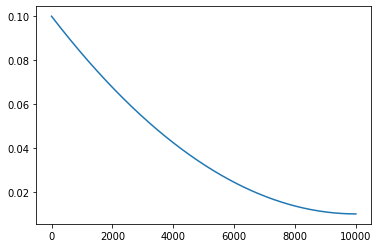

In [15]:
initial_learning_rate = 0.1
end_learning_rate = 0.01
decay_steps = 10000
power=2

def decayed_learning_rate(step, decay_steps=decay_steps):
    decay_steps = decay_steps * math.ceil(step / decay_steps)
    return ((initial_learning_rate - end_learning_rate) *
          math.pow(1 - step / decay_steps, power)
         ) + end_learning_rate

steps = list(range(1, decay_steps+1))
lr = [decayed_learning_rate(step) for step in steps]

plt.plot(steps, lr)
plt.show()